In [12]:
import pandas as pd
import numpy as np
import geopandas
%matplotlib inline

# Parks

In [13]:
rec = pd.read_csv("City of Pittsburgh Playing Fields.csv", index_col = "id")
numrec = rec.groupby('neighborhood').count()
playground = pd.read_csv("Playgrounds.csv")
play = playground.groupby('neighborhood').count()
recreation = pd.concat([numrec, play])
court = pd.read_csv("Courts and Rinks.csv")
court = court.groupby('neighborhood').count()
recreation = pd.concat([recreation, court])['park']
recreation = pd.DataFrame(recreation)
recreation = recreation.groupby('neighborhood').sum()
rec = recreation.sort_values(by=['park'], ascending=False)
area = pd.read_csv("Neighborhood Size.csv")
mask = area['acres'] > 0
area = area[mask]
area = area.groupby('hood').sum()['acres']
newarea = pd.DataFrame(area)
recreation = recreation.reset_index()
newarea = newarea.reset_index()
reca = newarea.merge(recreation, left_on="hood", right_on ="neighborhood")
reca.drop(labels = 'neighborhood', axis = 1)
recbyarea = reca['park'] / reca['acres']
recbyarea = pd.DataFrame(recbyarea, columns = ["parks per acre"])
reca = reca.merge(recbyarea, left_index=True, right_index=True)
reca = reca.sort_values(by = ['parks per acre'], ascending=False)

In [14]:
parkranks = {}
counter = 0
prev = -1
same = 1
for index,row in reca.iterrows():
    if row['parks per acre'] == prev:
        same = same + 1
    else:
        counter = counter + same
        same = 1
    parkranks[row['hood']]= counter
    prev = row['parks per acre']
parkranks = parkranks.items()
column = ["neighborhood","parkrank"]
parkranks = pd.DataFrame(parkranks, columns=column)
parkranks

,neighborhood,parkrank
0,Allegheny Center,1
1,Regent Square,2
2,Beltzhoover,3
3,Manchester,4
4,Troy Hill,5
...,...,...
66,Homewood North,67
67,Arlington,68
68,Point Breeze,69
69,Hays,70


# Crime

In [15]:
Arrest = pd.read_csv("Arrest in Pittsburgh.csv")
arrest = Arrest.groupby('INCIDENTNEIGHBORHOOD').count().sort_values(by=['OFFENSES'], ascending=True)

In [16]:
crimeranks = {}
counter = 0
prev = -1
same = 1
for index,row in arrest.iterrows():
    if row['OFFENSES'] == prev:
        same = same + 1
    else:
        counter = counter + same
        same = 1
    crimeranks[index]= counter
    prev = row['OFFENSES']
crimeranks = crimeranks.items()
column = ["neighborhood","crimerank"]
crimeranks = pd.DataFrame(crimeranks, columns=column)
crimeranks

,neighborhood,crimerank
0,Mt. Oliver Neighborhood,1
1,New Homestead,2
2,Swisshelm Park,2
3,Ridgemont,4
4,Chartiers City,5
...,...,...
92,East Liberty,93
93,Carrick,94
94,East Allegheny,95
95,Central Business District,96


# Education

In [17]:
Enrollment = pd.read_csv("Enrollment by Neighborhood 2020-21 school yr.csv")
Total_Enrollment_Year = Enrollment.groupby('neighborhood').sum()
tey = Total_Enrollment_Year.sort_values(by=["total_students_enrolled"],ascending=False)
tey = pd.DataFrame(tey)

In [18]:
edranks = {}
counter = 0
prev = -1
same = 1
for index,row in tey.iterrows():
    if row['total_students_enrolled'] == prev:
        same = same + 1
    else:
        counter = counter + same
        same = 1
    edranks[index]= counter
    prev = row['total_students_enrolled']
edranks = edranks.items()
column = ["neighborhood","edrank"]
edranks = pd.DataFrame(edranks, columns=column)
edranks

,neighborhood,edrank
0,Carrick,1
1,Brookline,2
2,Beechview,3
3,Sheraden,4
4,Squirrel Hill South,5
...,...,...
86,North Oakland,83
87,South Shore,83
88,Ridgemont,83
89,Golden Triangle,83


In [19]:
ranking = crimeranks.merge(edranks)
ranking = ranking.merge(parkranks)
ranking.set_index('neighborhood')

,crimerank,edrank,parkrank
neighborhood,,,
New Homestead,2,68,60
Swisshelm Park,2,75,49
East Carnegie,9,82,43
Oakwood,9,67,14
Regent Square,11,77,2
...,...,...,...
Sheraden,92,4,22
East Liberty,93,15,17
Carrick,94,1,51


In [21]:
avgrank = (ranking['crimerank'] + ranking['edrank'] + ranking['parkrank']) / 3
avgrank = pd.DataFrame(avgrank, columns=['avg'])
avgrank = ranking.merge(avgrank, left_index=True, right_index=True)
avg = avgrank.sort_values(by=['avg'],ascending=True)
avg

,neighborhood,crimerank,edrank,parkrank,avg
28,Terrace Village,45,23,12,26.666667
16,Morningside,29,43,10,27.333333
36,Highland Park,56,21,8,28.333333
22,Manchester,38,46,4,29.333333
34,Beltzhoover,53,34,3,30.000000
...,...,...,...,...,...
44,Central Oakland,67,83,31,60.333333
70,South Side Flats,97,56,38,63.666667
31,Strip District,50,83,62,65.000000
64,Bluff,90,73,64,75.666667


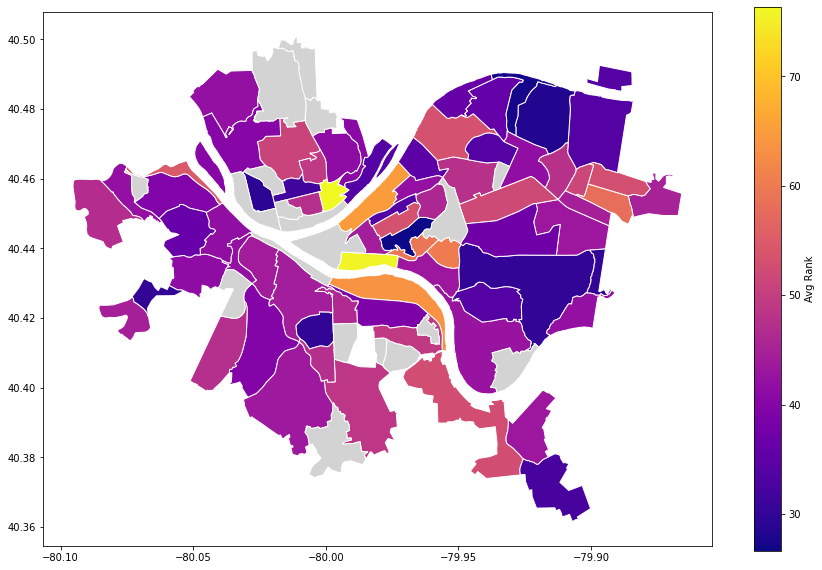

In [28]:
neighborhoods = geopandas.read_file("Neighborhoods/Neighborhoods_.shp")
rec_map = neighborhoods.merge(avg, how='left', left_on='hood', right_on='neighborhood')
rec_map.plot(column='avg', # set the data to be used for coloring
               cmap='plasma',              # choose a color palette
               edgecolor="white",        # outline the districts in white
               legend=True,              # show the legend
               legend_kwds={'label': "Avg Rank"}, # label the legend
               figsize=(15, 10),         # set the size
               missing_kwds={"color": "lightgrey"} # set disctricts with no data to gray
               )